# Using LoRA adaptors to augment diffusion models 

In this tutorial, we'll dive into the world of adapters, particularly focusing on LoRA (Low-Rank Adaptation), through the integration with 🤗 Transformers and 🤗 Diffusers. Adapters allow for the efficient customization of pre-trained models across various tasks and styles, with LoRA standing out for its efficiency and flexibility. You'll learn how to load, manage, and utilize these adapters using the powerful 🤗 PEFT (Parameter-Efficient Fine-Tuning) integration in Diffusers.

### An intuitive primer on LoRA
A LoRA adapter acts as a smart, lightweight modification layer within a diffusion model, enabling it to adapt to new tasks or styles without overhauling the entire network. Imagine it as a highly skilled artist who can quickly learn new painting techniques by merely adjusting a few brushes, rather than relearning their craft from scratch. This allows for efficient customization and experimentation, making it possible to achieve diverse and tailored outputs with minimal computational cost. 

This tutorial was adapted from a [Diffusers tutorial]("https://huggingface.co/docs/diffusers/main/en/tutorials/using_peft_for_inference"). The 1-click deployment is powered by [Brev]("brev.dev") 🤙

#### Step 1: Install the required libraries 

In [ ]:
!pip install -q transformers accelerate peft diffusers

#### Step 2: Create a diffusion pipline 

Here was use a Stable Diffusion XL (SDXL) checkpoint

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.float16).to("cuda")

#### Step 3: Load your LoRA adaptor

Next, load a [CiroN2022/toy-face]("https://huggingface.co/CiroN2022/toy-face") adapter with the [`load_lora_weights()`]("https://huggingface.co/docs/diffusers/main/en/api/loaders/lora#diffusers.loaders.StableDiffusionXLLoraLoaderMixin.load_lora_weights") method. With the 🤗 PEFT integration, you can assign a specific adapter_name to the checkpoint, which let’s you easily switch between different LoRA checkpoints. Let’s call this adapter "toy".

In [2]:
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

Make sure to include the token `toy_face` in the prompt.

  0%|          | 0/30 [00:00<?, ?it/s]

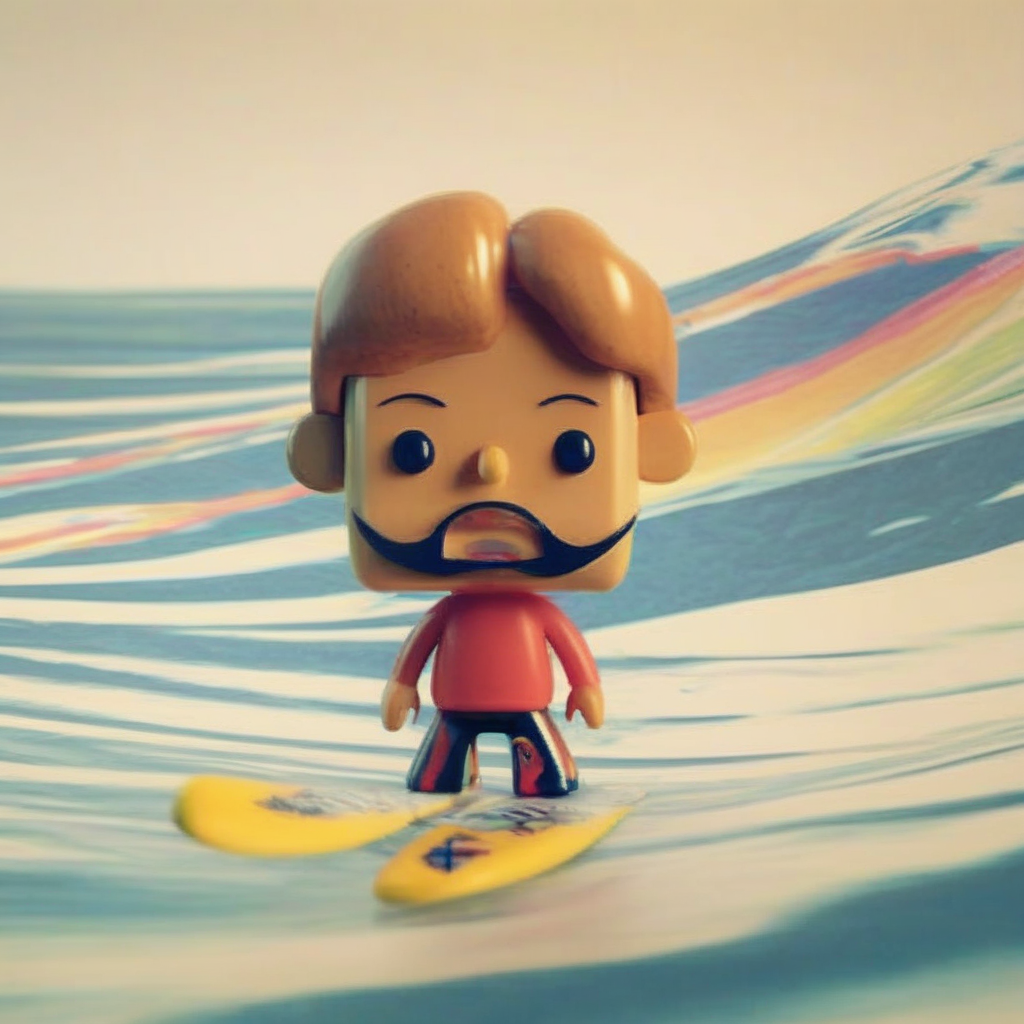

In [3]:
prompt = "toy_face of a surfer"

lora_scale= 0.9
image = pipe(
    prompt, 
    num_inference_steps=30, 
    cross_attention_kwargs={"scale": lora_scale}, 
    generator=torch.manual_seed(0)
).images[0]
image

With the `adapter_name` paramter, it is really easy to use another adapter for inference! Load the [nerijs/pixel-art-xl]("https://huggingface.co/nerijs/pixel-art-xl") adapter that has been fine-tuned to generate pixel art images and call it "pixel".

The pipeline automatically sets the first loaded adapter ("toy") as the active adapter, but you can activate the "pixel" adapter with the set_adapters() method:

In [4]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters("pixel")

Make sure you include the token `pixel art` in your prompt to generate a pixel art image:

  0%|          | 0/30 [00:00<?, ?it/s]

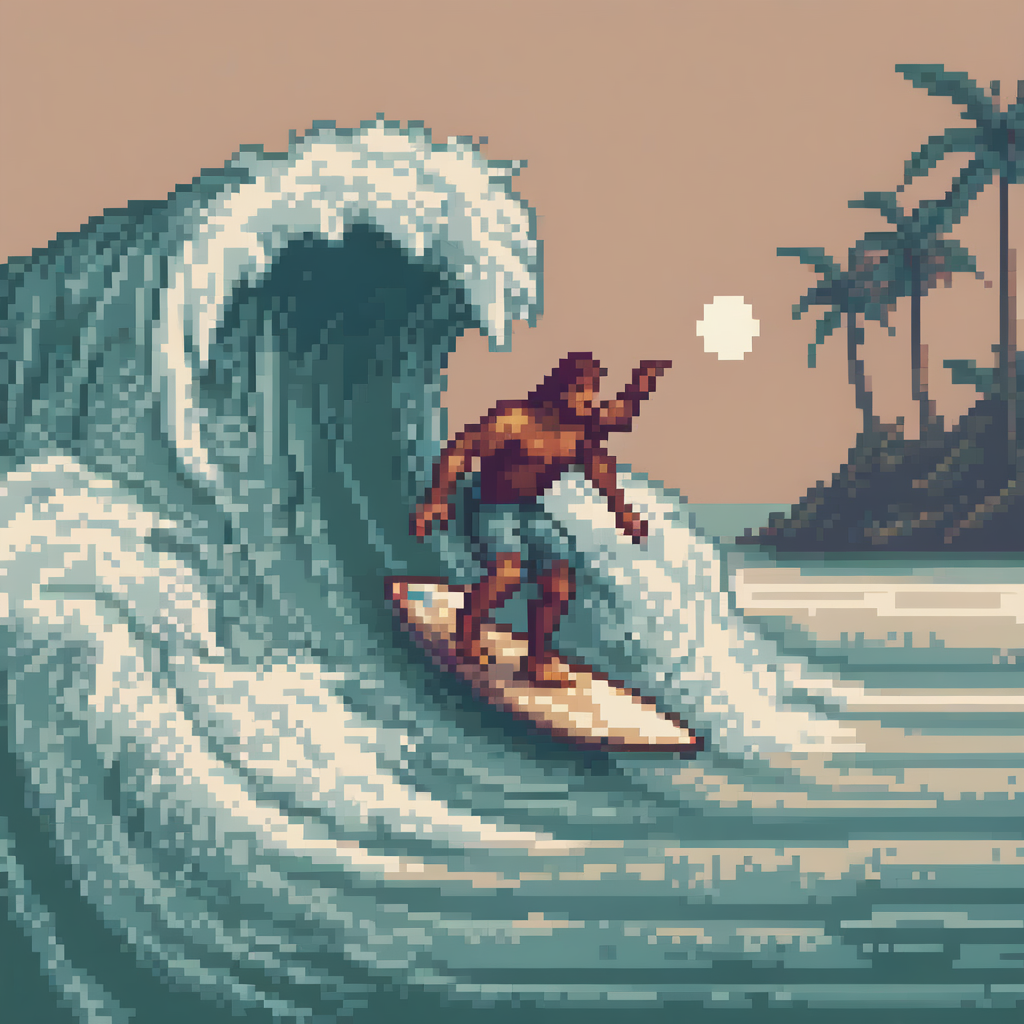

In [5]:
prompt = "a surfer surfing on a wave, pixel art"
image = pipe(
    prompt, 
    num_inference_steps=30, 
    cross_attention_kwargs={"scale": lora_scale}, 
    generator=torch.manual_seed(0)
).images[0]
image

#### Step 4: Merge adapters 

With diffusers, you can quickly merge different adapter checkpoints for inference to blend their styles

Once again, use the [`set_adapters()`]("https://huggingface.co/docs/diffusers/main/en/api/loaders/unet#diffusers.loaders.UNet2DConditionLoadersMixin.set_adapters") method to activate the pixel and toy adapters and specify the weights for how they should be merged.

In [6]:
pipe.set_adapters(["pixel", "toy"], adapter_weights=[0.5, 1.0])

LoRA checkpoints in the diffusion community are almost always obtained with [DreamBooth]("https://huggingface.co/docs/diffusers/main/en/training/dreambooth"). DreamBooth training often relies on “trigger” words in the input text prompts in order for the generation results to look as expected. When you combine multiple LoRA checkpoints, it’s important to ensure the trigger words for the corresponding LoRA checkpoints are present in the input text prompts.

Remember to use the trigger words for [CiroN2022/toy-face]("https://huggingface.co/CiroN2022/toy-face") and [nerijs/pixel-art-xl]("https://huggingface.co/nerijs/pixel-art-xl") (these are found in their repositories) in the prompt to generate an image.

  0%|          | 0/30 [00:00<?, ?it/s]

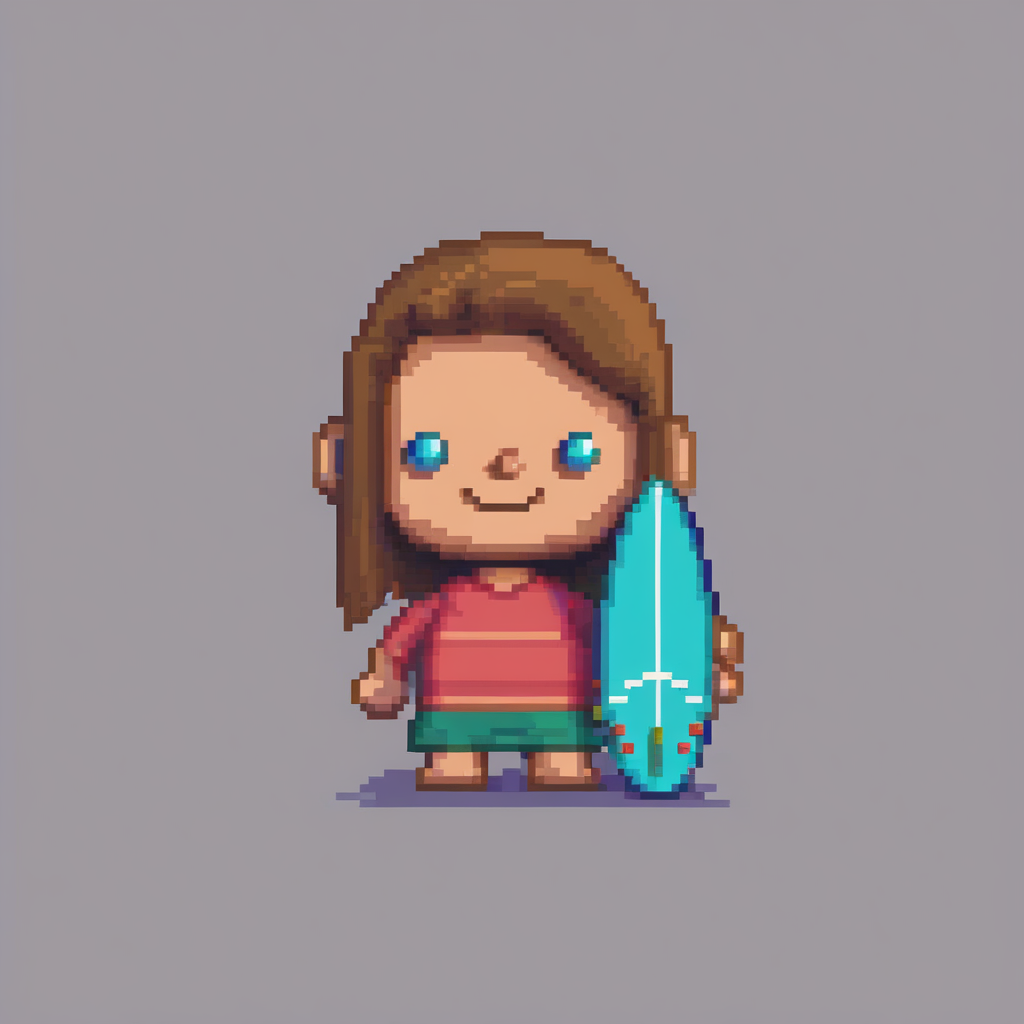

In [7]:
prompt = "toy_face of a surfer, pixel art"
image = pipe(
    prompt, 
    num_inference_steps=30, 
    cross_attention_kwargs={"scale": 1.0}, 
    generator=torch.manual_seed(0)
).images[0]
image

Impressive! As you can see, the model generated an image that mixed the characteristics of both adapters.

Through its PEFT integration, Diffusers also offers more efficient merging methods which you can learn about in the [Merge LoRAs]("https://huggingface.co/docs/diffusers/main/en/using-diffusers/merge_loras") guide!

To return to only using one adapter, use the [`set_adapters()`]("https://huggingface.co/docs/diffusers/main/en/api/loaders/unet#diffusers.loaders.UNet2DConditionLoadersMixin.set_adapters") method to activate the "toy" adapter

In [ ]:
pipe.set_adapters("toy")

prompt = "toy_face of a racecar driver"
lora_scale= 0.9
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

Or to disable all adapters entirely, use the `disable_lora()` method to return the base model.

In [ ]:
pipe.disable_lora()

prompt = "a racecar driver, pixel art"
lora_scale= 0.9
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

#### Step 5: Manage active adapters

You have attached multiple adapters in this tutorial, and if you’re feeling a bit lost on what adapters have been attached to the pipeline’s components, use the `get_active_adapters()` method to check the list of active adapters:

In [ ]:
active_adapters = pipe.get_active_adapters()
active_adapters

You can also get the active adapters of each pipeline component with `get_list_adapters()`:

In [ ]:
list_adapters_component_wise = pipe.get_list_adapters()
list_adapters_component_wise